In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import time
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score

sys.path.append('/Users/yantingting/PycharmProjects/modeling')
sys.setrecursionlimit(100000)
import plot_tools as pl
import metrics
import summary_statistics as ss
import feature_selection as fs
from data_io_utils import *
import data_processing as dp


In [3]:
file_path_in = '/Users/yantingting/Documents/海外风控/巴西/拼接数据&模型初版/'
file_path_model = '/Users/yantingting/Documents/海外风控/巴西/模型初版_基本信息/'

In [4]:
drop_list = ['age']

In [5]:
df_var = pd.read_csv(file_path_in + 'df_var_all.csv')
df_var = df_var.drop(drop_list, axis = 1)
df_var.shape
df_train1= df_var[df_var['is_sample'] == 1]
df_train1['flag_result'].shape
df_train2= df_var[df_var['is_sample'] == 2]
df_train2['flag_result'].shape
df_test= df_var[df_var['is_sample'] == 3]
df_test['flag_result'].shape
df_var.head()


(23927, 220)

(14969,)

(3743,)

(5215,)

,loan_id,DATE,flag_result,is_sample,var17,var18,var9,var36,len_zipcode,society,...,app_size,phone_charging_status,electric_quantity,gps,available_memory_size,total_memory_size,available_capacity_size,disk_size,vpn,net_type
0,3808870852,20191014,1,1,NaN,623.0,1032.0,0.0,8,0,...,234,0.0,2.0,1,464.00,1863.68,2406.40,23930.88,0,1.0
1,3808871384,20191015,1,1,NaN,489.0,2040.0,0.0,8,0,...,294,0.0,2.0,1,367.00,1955.84,1873.92,12103.68,0,1.0
2,3808917409,20191017,1,1,NaN,693.0,2800.0,0.0,8,0,...,343,0.0,8.0,1,314.00,1935.36,8499.20,26030.08,0,4.0
3,3808927120,20191018,1,1,624.0,NaN,6985.0,0.0,8,0,...,207,0.0,18.0,1,790.00,4003.84,29347.84,50585.60,0,4.0
4,3808927373,20191018,1,2,NaN,553.0,3000.0,0.0,8,0,...,303,2.0,20.0,1,1044.48,6051.84,76349.44,121856.00,0,4.0


In [6]:
df_var['var2-O'].value_counts()

1    15392
0     8535
Name: var2-O, dtype: int64

In [7]:
df_var = df_var.fillna(-1)
X_train1 = df_train1.iloc[:, 4:]
y_train1 = df_train1['flag_result'].astype(int)
X_train2 = df_train2.iloc[:, 4:]
y_train2 =df_train2['flag_result'].astype(int)
X_test = df_test.iloc[:, 4:]
y_test = df_test['flag_result'].astype(int)

In [8]:
'''
step2 训练模型，初筛变量
'''
model = XGBClassifier()
eval_set = [(X_train2, y_train2)]
model.fit( X_train1,  y_train1,  early_stopping_rounds=10,  eval_metric="auc",  eval_set=eval_set,  verbose=False)
y2_pred = model.predict(X_train2)
predictions = [round(value) for value in y2_pred]
accuracy = accuracy_score(y_train2, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


'\nstep2 训练模型，初筛变量\n'

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy: 91.77%


In [9]:
all_features = list(X_train1.columns)
feature_importance = model.feature_importances_
features_in_model = all_features
features_in_model = [all_features[i] for i in range(len(feature_importance)) if feature_importance[i] > 0]

In [10]:
# 创建新的dataframe存储变量的重要性
var_importance = pd.DataFrame(columns=["var_name", 'importance'])
var_importance['var_name'] = all_features
var_importance['importance'] = feature_importance
var_importance.sort_values('importance',  ascending=False).to_csv(file_path_model + 'var_importance.csv')
var_importance.sort_values('importance',  ascending=False).head(10)


,var_name,importance
38,var22-APROVA,0.382679
54,rate_low_freq_app,0.036359
20,var10-Autonomos,0.029490
7,var2-O,0.024295
51,cnt_app,0.022505
31,var21-FALHA,0.017487
41,var31-NAO_CONSTAM_OCORRENCIAS,0.015378
0,var17,0.014746
85,Empréstimo Pessoal,0.012549
1,var18,0.011894


In [11]:
var_dict = pd.read_csv(file_path_in + 'var_dict_all.csv')
var_dict = var_dict[~var_dict['指标英文'].isin(drop_list)]
var_dict.head()


,数据源,指标英文,指标中文,数据类型
0,bank,var17,var17,float64
1,bank,var18,var18,float64
2,bank,var9,var9,float64
3,bank,var36,var36,float64
5,bank,len_zipcode,len_zipcode,int64


In [12]:
'''
# 计算PSI  IV
'''
time1 = time.time()
args_dict = {
    'random_forest': {
    'grid_search': False,  # 选择了True则会进行网格筛选速度会比较慢
    'param': None
    },
    'xgboost': {
    'grid_search': False,
    'param': None
    }
}
methods = [
    'random_forest',
    # 'lasso',
    'xgboost'
]

fs_obj = fs.FeatureSelection()
bin_obj = metrics.BinWoe()
model_data_final = df_train1.copy()
features_var_dict = list(var_dict['指标英文'])
X_IV = model_data_final[features_var_dict]
y_IV = model_data_final['flag_result'].astype(int)
X_cat_train, X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_IV, y_IV, var_dict, args_dict, methods, num_max_bins=5)
rebin_spec_bin_adjusted = {k: v for k, v in rebin_spec.items() if k in features_var_dict}
# 输出的是变量的分箱
X_cat_train = bin_obj.convert_to_category( model_data_final[features_var_dict],  var_dict, rebin_spec_bin_adjusted)

model_data_final['appmon'] = model_data_final['DATE'].apply(lambda x: 1 if x > 20191001 else 0)

X_cat_train_with_y_appmon = pd.merge(X_cat_train, model_data_final[['flag_result', 'appmon']], left_index=True,
                                     right_index=True)
var_dist_badRate_by_time = ss.get_badRate_and_dist_by_time(X_cat_train_with_y_appmon, features_var_dict, 'appmon',   'flag_result')
var_dist_badRate_by_time.columns = [
    'varName',
    'bins',
    'total1',
    'tolal2',
    'bad1',
    'bad2',
    'dist1',
    'dist2',
    'badrate1',
    'badrate2']
var_dist_badRate_by_time.to_csv(file_path_model + "var_dist_badRate_by_time.csv", index=False, sep=',')
time2 = time.time()
print('run_time : ', time2 - time1)

'\n# 计算PSI  IV\n'

Warnings: downflag variable is not in downflagmap provided for bank
Warnings: downflag variable is not in downflagmap provided for app_freq
Warnings: downflag variable is not in downflagmap provided for app_tfidf
Warnings: downflag variable is not in downflagmap provided for contact
Warnings: downflag variable is not in downflagmap provided for deviceinfo
Warnings: downflag variable is not in downflagmap provided for othersdk


/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.940918	test-auc:0.940023
[10]	train-auc:0.954647	test-auc:0.952497
[20]	train-auc:0.958986	test-auc:0.956207
[30]	train-auc:0.962037	test-auc:0.958534
[40]	train-auc:0.963881	test-auc:0.959558
[50]	train-auc:0.965704	test-auc:0.960003
[60]	train-auc:0.967103	test-auc:0.960426
[70]	train-auc:0.969398	test-auc:0.960795
[80]	train-auc:0.971395	test-auc:0.961085
[90]	train-auc:0.973329	test-auc:0.96131
[100]	train-auc:0.975022	test-auc:0.961531
[110]	train-auc:0.976565	test-auc:0.961956
[120]	train-auc:0.978029	test-auc:0.962385
[130]	train-auc:0.979356	test-auc:0.96274
[140]	train-auc:0.980617	test-auc:0.962908
[150]	train-auc:0.981796	test-auc:0.963117
[160]	train-auc:0.982667	test-auc:0.963203
[170]	train-auc:0.983606	test-auc:0.963269
[180]	train-auc:0.984531	test-auc:0.963456
[190]	train-auc:0.985422	test-auc:0.96336
[200]	train-auc:0.986147	test-auc:0.96347
[210]	train-auc:0.986899	test-auc:0.963515
[220]	train-auc:0.987663	test-auc:0.963464
[230]	train-auc:0.988321	t

In [13]:
var_dist_badRate_by_time_ = pd.read_csv(file_path_model + "var_dist_badRate_by_time.csv")
# CALCULATE PSI
var_dist_badRate_by_time_['PSI'] = (var_dist_badRate_by_time_['dist1'] - var_dist_badRate_by_time_['dist2']) * np.log(
    var_dist_badRate_by_time_['dist1'] / var_dist_badRate_by_time_['dist2'])

var_psi = pd.DataFrame(var_dist_badRate_by_time_.groupby(['varName'])['PSI'].agg(['sum']))
var_psi['varName'] = var_psi.index
var_psi.columns = ['PSI', 'varName']
var_psi = var_psi[[ 'varName' ,  'PSI']]
features_stable = list(var_psi[var_psi['PSI'] <= 0.2]['varName'])
features_unstable = list(var_psi[var_psi['PSI'] > 0.2]['varName'])
features_iv_hi = list(ranking_result[ranking_result['IV'] >= 0.02]['指标英文'])
features_iv_lo = list(ranking_result[ranking_result['IV'] < 0.02]['指标英文'])
var_psi.to_csv(file_path_model + "var_psi.csv", index=False, sep=',')
woe_iv_df.to_csv(file_path_model + "woe_iv_df_.csv", index=False, sep=',')
features_remove = set(features_unstable + features_iv_lo)
features_in_model = [ele for ele in features_in_model if ele not in features_remove]
features =pd.DataFrame({"var": features_in_model})
features['数据源'] = features['var'].map(lambda x: dict(zip(var_dict['指标英文'], var_dict['数据源']))[x])
features = features[features['数据源'] == 'bank']
features_in_model = features['var'].to_list()
features.to_csv(file_path_model + "features_in_model.csv")
features.head()


,var,数据源
0,var17,bank
1,var18,bank
2,var9,bank
3,var2-O,bank
4,var3-0,bank


In [14]:
'''
-------------------------------
XGB tuning parameters
-------------------------------
'''
'''
参数调优的一般步骤
1. 确定学习速率和提升参数调优的初始值
2. max_depth 和 min_child_weight 参数调优
3. gamma参数调优
4. subsample 和 colsample_bytree 参数优
5. 正则化参数alpha调优
6. 降低学习速率和使用更多的决策树
'''

df_train1_learn = df_train1[features_in_model]
df_train2_learn = df_train2[features_in_model]
X_train1 = df_train1_learn.values
X_train2 = df_train2_learn.values


param_test1 = {
    'max_depth': range(3, 10, 1),
    'min_child_weight': range(1, 6, 1)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, gamma=0, subsample=0.7,
                                                max_depth=4, colsample_bytree=1, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)

gsearch1.fit(X_train1, y_train1)

best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']
print('1:', gsearch1.best_score_)

param_test2 = {'gamma': [i / 10.0 for i in range(0, 5)]}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, subsample=0.7, colsample_bytree=1,
                                                max_depth=best_max_depth,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train1, y_train1)
best_gamma = gsearch2.best_params_['gamma']
print('2:', gsearch2.best_score_)


param_test3 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, max_depth=best_max_depth, gamma=best_gamma,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train1, y_train1)
best_subsample = gsearch3.best_params_['subsample']
best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
print('3:', gsearch3.best_score_)


param_test4 = {'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(X_train1, y_train1)
best_reg_alpha = gsearch4.best_params_['reg_alpha']
print('4:', gsearch4.best_score_)


param_test5 = {'n_estimators': range(50, 500, 20)}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                                                reg_alpha=best_reg_alpha,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(X_train1, y_train1)
best_n_estimators = gsearch5.best_params_['n_estimators']
print('5:', gsearch5.best_score_)


param_test6 = {'learning_rate': [i / 100.0 for i in range(0, 30)]}
gsearch6 = GridSearchCV(estimator=XGBClassifier(max_depth=best_max_depth, gamma=best_gamma, n_estimators=best_n_estimators,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample, reg_alpha=best_reg_alpha,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(X_train1, y_train1)
best_learning_rate = gsearch6.best_params_['learning_rate']
print('6:', gsearch6.best_score_)

# 用获取得到的最优参数再次训练模型
best_xgb = XGBClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, max_depth=best_max_depth,
                         gamma=best_gamma, colsample_bytree=best_colsample_bytree, subsample=best_subsample, reg_alpha=best_reg_alpha,
                         min_child_weight=best_min_child_weight,
                         objective='binary:logistic', nthread=6, scale_pos_weight=1, eval_metric='auc', seed=27)
print(best_xgb)
best_xgb.fit(X_train1, y_train1)
print('process is end!')


'\n-------------------------------\nXGB tuning parameters\n-------------------------------\n'

'\n参数调优的一般步骤\n1. 确定学习速率和提升参数调优的初始值\n2. max_depth 和 min_child_weight 参数调优\n3. gamma参数调优\n4. subsample 和 colsample_bytree 参数优\n5. 正则化参数alpha调优\n6. 降低学习速率和使用更多的决策树\n'

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.7, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_s

1: 0.951354010701938


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.7, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbo

2: 0.951354010701938


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=Tru

3: 0.9520998603179155


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc

4: 0.9520998603179155


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(50, 500, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', 

5: 0.9520998603179155


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                           0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                    

6: 0.9520998603179155
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=90, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=90, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

process is end!


In [15]:
def Prob2Score(prob, basePoint, PDO):
    y = np.log(prob / (1 - prob))
    return (basePoint + PDO / np.log(2) * (-y)).astype(int)

In [16]:
'''
-------------------------------
Model scoring
-------------------------------
'''
df_all_learn = df_var[features_in_model]
X_df_all = df_all_learn.values
y_df_all = df_var['flag_result'].astype(int)
y_df_all_pred = best_xgb.predict_proba(X_df_all)[:, 1]

score_all = [round(Prob2Score(value, 600, 20)) for value in y_df_all_pred]
predictions = [round(value) for value in y_df_all_pred]
mylist = ['loan_id', 'flag_result', 'DATE']
# SettingWithCopyWarning出现的原因  链式赋值/Chained Assignment  所以在后边加一个copy()
df_all_result = df_var[mylist].copy()
df_all_result.loc[:, 'predictions'] = predictions
df_all_result.loc[:, 'y_df_pred'] = y_df_all_pred
df_all_result.loc[:, 'score_all'] = score_all
df_all_result.loc[:, 'group'] = pd.qcut(pd.DataFrame(
    score_all)[0], q=10, duplicates='drop', precision=0).astype(str)
df_all_result.to_csv(file_path_model + "df_all_result.csv")
accuracy = accuracy_score(y_df_all, predictions)
print("AccuracyAll: %.2f%%" % (accuracy * 100.0))



'\n-------------------------------\nModel scoring\n-------------------------------\n'

AccuracyAll: 92.62%


In [17]:

'''
-------------------------------
Model evaluation
-------------------------------
'''

df_train1_result = pd.merge(df_train1[['loan_id']], df_all_result, on='loan_id', how='left' )
df_train2_result = pd.merge(df_train2[['loan_id']], df_all_result, on='loan_id', how='left' )
df_test_result = pd.merge(df_test[['loan_id']], df_all_result, on='loan_id', how='left' )

# AUC+Accuracy
train1_auc = roc_auc_score(df_train1_result['flag_result'], df_train1_result['y_df_pred'])
print("train1_auc: %.2f" % train1_auc)
train2_auc = roc_auc_score(df_train2_result['flag_result'], df_train2_result['y_df_pred'])
print("train2_auc: %.2f" % train1_auc)
test_auc = roc_auc_score(df_test_result['flag_result'], df_test_result['y_df_pred'])
print("test_auc: %.2f" % test_auc)
train1_accuracy = accuracy_score(
    df_train1_result['flag_result'],
    df_train1_result['predictions'])
print("train1_accuracy: %.2f%%" % (train1_accuracy * 100.0))
train2_accuracy = accuracy_score(
    df_train2_result['flag_result'],
    df_train2_result['predictions'])
print("train2_accuracy: %.2f%%" % (train2_accuracy * 100.0))
test_accuracy = accuracy_score(
    df_test_result['flag_result'],
    df_test_result['predictions'])
print("test_accuracy: %.2f%%" % (test_accuracy * 100.0))

# KS
def ModelBin(data):
    bad = data['flag_result'].sum()
    good = data['flag_result'].count() - bad
    df = data.groupby(data['group'])
    df1 = pd.DataFrame()
    df1['total'] = df["flag_result"].count()
    df1['bad'] = df["flag_result"].sum()
    df1['good'] = df1['total'] - df1["bad"]
    df1['per%'] = df1['total'] / data['flag_result'].count()
    df1['overdue'] = df1['bad'] / df1['total']
    df1['cum_bad'] = df1['bad'].cumsum(0) / bad
    df1['cum_good'] = df1['good'].cumsum(0) / good
    df1["KS"] = df1['cum_bad'] - df1['cum_good']
    df1["cum_overdue"] = df1["bad"].cumsum(0) / df1['total'].cumsum(0)

    df1.columns = ["total", "bad", "good", "per%", "overdue",
                   "cum_bad", "cum_good", "KS", "cum_overdue"]
    return df1


writer = pd.ExcelWriter(file_path_model + "result.xlsx")
ModelBin(df_train1_result).to_excel(writer, sheet_name="train1")
ModelBin(df_train2_result).to_excel(writer, sheet_name="train2")
ModelBin(df_test_result).to_excel(writer, sheet_name="test")
writer.save()

'''
-------------------------------
SAVE MODEL
-------------------------------
'''
best_xgb.save_model(file_path_model + 'bx_sdk_model.model')


'\n-------------------------------\nModel evaluation\n-------------------------------\n'

train1_auc: 0.97
train2_auc: 0.97
test_auc: 0.95
train1_accuracy: 92.74%
train2_accuracy: 91.58%
test_accuracy: 93.04%


'\n-------------------------------\nSAVE MODEL\n-------------------------------\n'

In [18]:
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
final_importance = best_xgb.feature_importances_
#存储模型最终的变量重要性
var_importance = pd.DataFrame(columns=["var_name", 'importance'])
var_importance['var_name'] = feature_list
var_importance['importance'] = final_importance
var_importance = var_importance.sort_values('importance',  ascending=False)
var_importance
# var_importance.sort_values('importance',  ascending=False).to_csv(file_path_model + 'var_importance_final.csv')

(15, 3)

,var_name,importance
12,var22-APROVA,0.604998
14,var31-NAO_CONSTAM_OCORRENCIAS,0.168320
13,var30-NAO_CONSTAM_OCORRENCIAS,0.092794
7,var10-Autonomos,0.030295
0,var17,0.021604
1,var18,0.012386
9,var10-Profissionais Liberais,0.012130
4,var3-0,0.010726
8,var10-Empresários,0.010361
11,var25-1.0,0.007752


<BarContainer object of 15 artists>

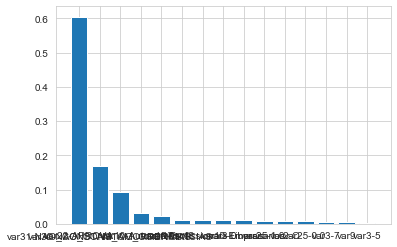

In [19]:
plt.bar(var_importance['var_name'], var_importance['importance'])

# 画图

(15, 3)

var17 is in processing




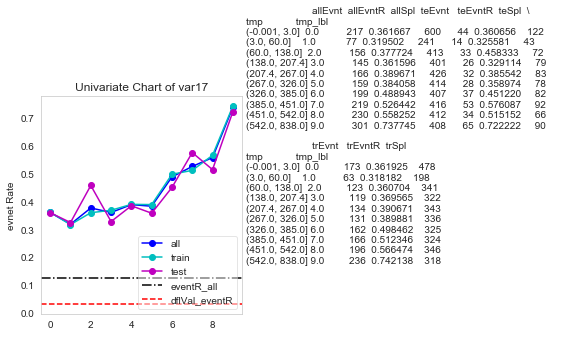

var18 is in processing




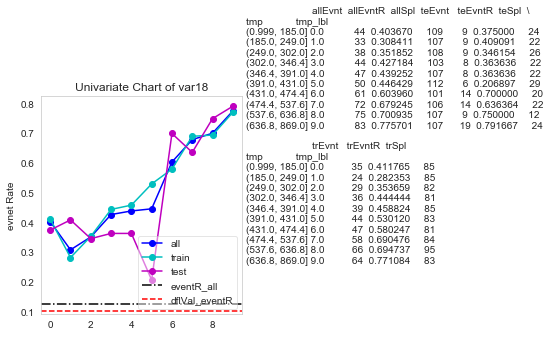

var9 is in processing




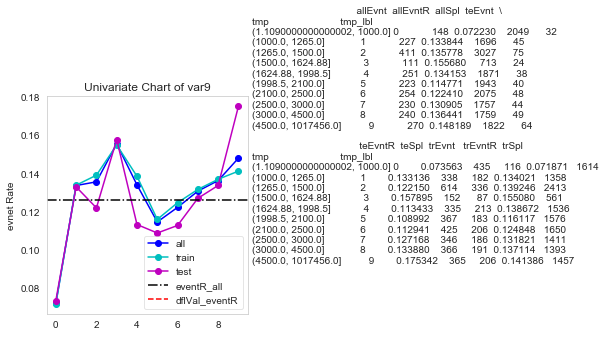

var2-O is in processing


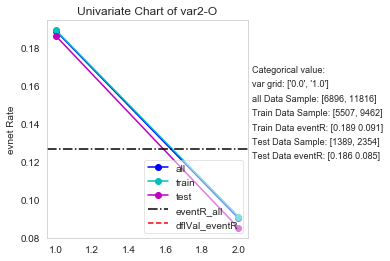

var3-0 is in processing


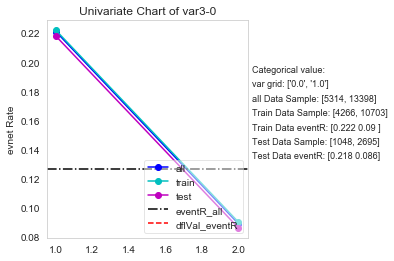

var3-5 is in processing


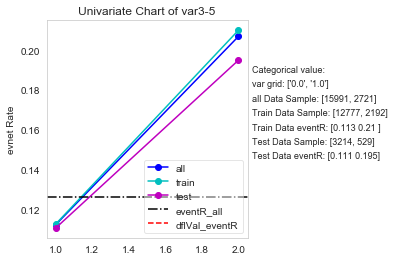

var3-7 is in processing


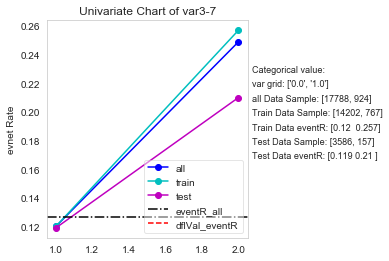

var10-Autonomos is in processing


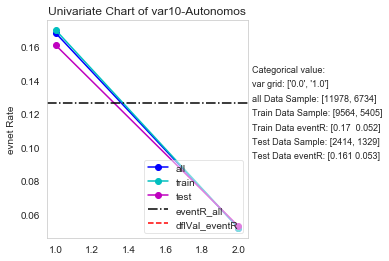

var10-Empresários is in processing


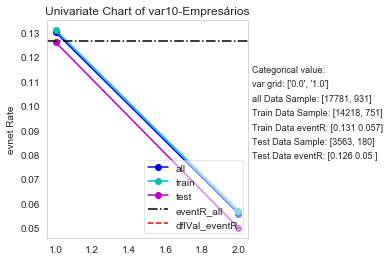

var10-Profissionais Liberais is in processing


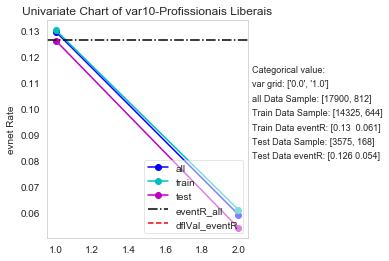

var25-0.0 is in processing


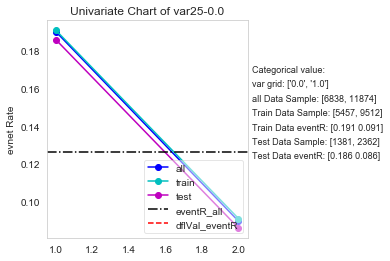

var25-1.0 is in processing


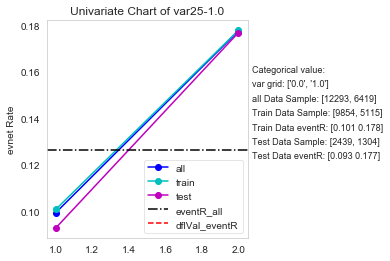

var22-APROVA is in processing


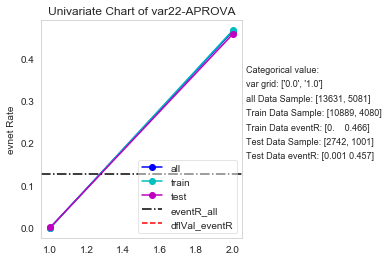

var30-NAO_CONSTAM_OCORRENCIAS is in processing


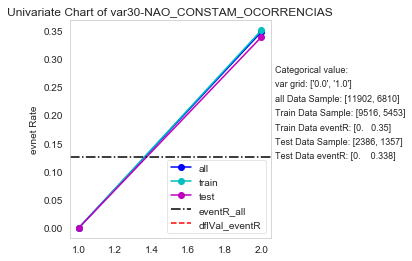

var31-NAO_CONSTAM_OCORRENCIAS is in processing


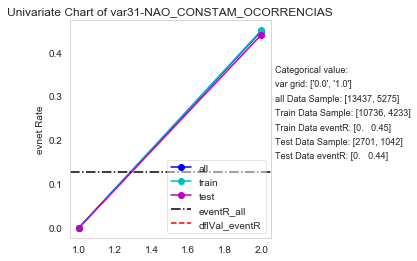

[]
run_time:  8.209988117218018


In [20]:
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
time1 = time.time()
df_train1_train2 = df_var[(df_var['is_sample'] == 1)|(df_var['is_sample'] == 2)]
df_train1 = df_var[df_var['is_sample'] == 1]
df_train2 = df_var[df_var['is_sample'] == 2]
wrong_list= []
for col in feature_list:
    print('{} is in processing'.format(col))
    try:
        pl.uniVarChart(df_train1_train2.fillna(-1),  col, target = 'flag_result', n_bins = 10, result_path=file_path_model ,dfltValue = -1, dftrain =df_train1.fillna(-1), dftest = df_train2.fillna(-1), 
                drawAll = True, drawTrTe = True)
    except IndexError:
        wrong_list.append(col)
        print('wrong!')
print(wrong_list)
time2 = time.time()
print('run_time: ', time2-time1)
            

In [21]:
# mymodel = xgb.Booster()
# model1 = mymodel.load_model(file_path_model + 'bx_sdk_model.model')

sys.path.append('/Users/yantingting/Documents/newgenie/newgenie')
var_importance= pd.read_csv(file_path_model + 'var_importance.csv', usecols=[1,2])
feature = pd.read_csv(file_path_model + "features_in_model.csv")
model_importance = pd.merge(feature[['var']], var_importance, left_on = 'var', right_on = 'var_name', how='left')
model_importance = model_importance.drop('var_name', axis = 1)
# model_importance.head()
test_pred = pd.concat([df_train1.iloc[:, 4:], df_train2.iloc[:, 4:]], axis =0)
model = xgb.Booster()
model.load_model(file_path_model + 'bx_sdk_model.model')
model_importance.head()
model_importance.columns = ['varName', 'importance']                       
import utils3.generate_report as gr
f_imp_list = gr.get_feature_importance(model_importance)
import utils3.plot_tools as pt
import matplotlib.pyplot as plt
RESULT_PATH = file_path_model
FIG_PATH = os.path.join(RESULT_PATH, 'figure', 'PDP')
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)

n=0
while n <len(f_imp_list):
    m = n+9
    features_draw=[i for i in f_imp_list[n:m]]
    select_features = model_importance['varName'].values.tolist()
    pt.pdpCharts9(model, test_pred, features_draw, select_features, n_bins=10, dfltValue = -1)
    path = os.path.join(FIG_PATH,"pdp_"+str(n)+"_"+str(m)+".png")
    plt.savefig(path, format='png', dpi=100)
    plt.close()
    n += 9
    
print('end!')

,var,importance
0,var17,0.014746
1,var18,0.011894
2,var9,0.003732
3,var2-O,0.024295
4,var3-0,0.009172


[<Figure size 1152x576 with 9 Axes>]

[<Figure size 1152x576 with 6 Axes>]

end!


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [22]:
from sklearn import metrics
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn import metrics
from matplotlib.pylab import rcParams
from sklearn.externals import joblib
import platform
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
rcParams['figure.figsize'] = 16,8

def calc_rate(df, y_true):
    return pd.DataFrame.from_dict(
        {
            'cntLoan': len(df),
            'event': df[y_true].sum(),
            'eventRate': df[y_true].mean()
        },
        orient='index').T


def show_result_new(df, y_pred, y_true, n_bins, feature_label='', result_path = None):
    '''
    模型预测结果的Lift Chart.

    :param df: 数据集, DataFrame.
    :param y_pred: 模型预测分数, str.
    :param y_true: 是否违约标签列, array[0, 1].
    :param n_bins: 分箱数量, int.
    :param feature_label:
    :return: Lift Chart, fone
    '''

    if feature_label == '':
        feature_label = y_pred
    df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')
    n_bins = len(df['bkl_%s' % y_pred].unique())
    print('分箱数量: ', n_bins)

    g_df = df.groupby('bkl_%s' % y_pred).apply(lambda x: calc_rate(x, y_true)).reset_index(level=1, drop=True)
    g_df['acmLoan'] = g_df['cntLoan'].cumsum()
    g_df['acmEvent'] = g_df['event'].cumsum()
    g_df['acmEventRate'] = g_df['acmEvent'] / g_df['acmLoan']
    g_df = g_df.reset_index()
    #print(g_df)
    # plot lift_chart - marginal
    plt.subplot(1, 2, 1)

    g_df.index = range(1, n_bins + 1)
    plt.plot(g_df.index, g_df['eventRate'], marker='o',
             label='Auc of %s:%d:%.3f' % (
                 feature_label, df.shape[0], np.round(metrics.roc_auc_score(df[y_true], df[y_pred]), 3)))  # linestyle='--'
    plt.title('EventRate in %d Quantiles' % n_bins)
    plt.ylabel('eventRate')
    plt.grid(True)
    plt.legend(fontsize=13, loc=2, framealpha=0.5)


    plt.subplot(1, 2, 2)
    plt.plot(g_df.index, g_df['acmEventRate'], marker='o',
             label='Auc of %s:%d:%.3f' % (
                 feature_label, df.shape[0], np.round(metrics.roc_auc_score(df[y_true], df[y_pred]), 3)))  # linestyle='--'
    plt.title('Accum-EventRate in %d Quantiles' % n_bins)
    plt.ylabel('accumEventRate')
    plt.grid(True)
    plt.legend(fontsize=13, loc=2, framealpha=0.5)
    rcParams['figure.figsize'] = 16, 8
    plt.tight_layout()
    if result_path is not None:
        result_path = os.path.join(result_path, 'figure/liftChart/')
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    plt.savefig(os.path.join(result_path, 'lift_chart_overall.png'), format='png', dpi=80)
    plt.show()
    return g_df

In [23]:
sys.path.append('/Users/yantingting/Documents/newgenie/newgenie')
import plot_tools as pt
import matplotlib.pyplot as plt
df_all_result = pd.read_csv(file_path_model + "df_all_result.csv")
df_train1_result = pd.merge(df_train1[['loan_id']], df_all_result, on='loan_id', how='left' )
df_train2_result = pd.merge(df_train2[['loan_id']], df_all_result, on='loan_id', how='left' )
df_test_result = pd.merge(df_test[['loan_id']], df_all_result, on='loan_id', how='left' )
train_pred = df_train1_result
test_pred = df_train2_result
testnew_pred= df_test_result
result_path = file_path_model
train_lc = show_result_new(train_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='train')
test_lc = show_result_new(test_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='test')
oot_lc = show_result_new(testnew_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='OOT')
plt.show()
plt.savefig('lift_chart_overall.png', dpi=100)
plt.close()


分箱数量:  10
分箱数量:  10
分箱数量:  10
